In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Load CSV into Dataframe


In [0]:
retail_df = spark.sql("select * from retail")
retail_df.show()

+----------+----------+--------------------+--------+-------------------+----------+-----------+--------------+
|invoice_no|stock_code|         description|quantity|       invoice_date|unit_price|customer_id|       country|
+----------+----------+--------------------+--------+-------------------+----------+-----------+--------------+
|    489434|     85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00|      6.95|      13085|United Kingdom|
|    489434|    79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00|      6.75|      13085|United Kingdom|
|    489434|    79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00|      6.75|      13085|United Kingdom|
|    489434|     22041|RECORD FRAME 7" S...|      48|2009-12-01 07:45:00|       2.1|      13085|United Kingdom|
|    489434|     21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00|      1.25|      13085|United Kingdom|
|    489434|     22064|PINK DOUGHNUT TRI...|      24|2009-12-01 07:45:00|      1.65|      13085|United K

In [0]:
retail_df.printSchema()

root
 |-- invoice_no: string (nullable = true)
 |-- stock_code: string (nullable = true)
 |-- description: string (nullable = true)
 |-- quantity: long (nullable = true)
 |-- invoice_date: timestamp (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- customer_id: long (nullable = true)
 |-- country: string (nullable = true)
 |-- price: double (nullable = true)
 |-- item_total: double (nullable = true)
 |-- year_month: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- year_month_int: integer (nullable = true)



# Data Preperation


In [0]:
from pyspark.sql.functions import col, to_timestamp, date_format
from pyspark.sql.types import LongType, DoubleType

retail_df = retail_df.withColumn("invoice_date", to_timestamp("invoice_date"))
retail_df = retail_df.withColumn("quantity", col("quantity").cast(LongType()))
retail_df = retail_df.withColumn("price", col("unit_price").cast(DoubleType()))

retail_df = retail_df.withColumn("item_total", col("quantity") * col("price"))
retail_df = retail_df.withColumn("year_month", date_format("invoice_date", "yyyyMM"))
retail_df = retail_df.withColumn("is_canceled", col("invoice_no").cast("string").startswith("C"))

retail_df.show(5)


+----------+----------+--------------------+--------+-------------------+----------+-----------+--------------+-----+------------------+----------+-----------+
|invoice_no|stock_code|         description|quantity|       invoice_date|unit_price|customer_id|       country|price|        item_total|year_month|is_canceled|
+----------+----------+--------------------+--------+-------------------+----------+-----------+--------------+-----+------------------+----------+-----------+
|    489434|     85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00|      6.95|      13085|United Kingdom| 6.95|              83.4|    200912|      false|
|    489434|    79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00|      6.75|      13085|United Kingdom| 6.75|              81.0|    200912|      false|
|    489434|    79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00|      6.75|      13085|United Kingdom| 6.75|              81.0|    200912|      false|
|    489434|     22041|RECORD FRAME 7" S

# Total Invoice Amount Distribution


In [0]:
invoice_totals = retail_df.groupBy("invoice_no").agg(
    F.sum("item_total").alias("invoice_amount")
)

invoice_totals.show()



+----------+-------------------+
|invoice_no|     invoice_amount|
+----------+-------------------+
|    489677|              192.0|
|   C491017|              -4.95|
|    491045|              303.2|
|    491658| 155.05999999999997|
|   C491705|              -22.5|
|   C492541|              -99.0|
|   C493168|-177.60000000000002|
|    493542|             118.75|
|    493977|             275.95|
|   C493984|             -10.43|
|    494244|             6711.0|
|    494277|            1335.92|
|   C494502|              -9.95|
|    495185|            2507.06|
|    495329|                0.0|
|    495594|                0.0|
|   C495697|-126.24999999999999|
|    495783|              48.96|
|    496171| 199.29999999999998|
|    496233| 188.82999999999998|
+----------+-------------------+
only showing top 20 rows



In [0]:
retail_df.printSchema()

root
 |-- invoice_no: string (nullable = true)
 |-- stock_code: string (nullable = true)
 |-- description: string (nullable = true)
 |-- quantity: long (nullable = true)
 |-- invoice_date: timestamp (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- customer_id: long (nullable = true)
 |-- country: string (nullable = true)
 |-- price: double (nullable = true)
 |-- item_total: double (nullable = true)
 |-- year_month: string (nullable = true)
 |-- is_canceled: boolean (nullable = true)

['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country', 'price', 'item_total', 'year_month', 'is_canceled']


# Monthly Placed and Canceled Orders

+--------------+------------+---------------+-------------+
|year_month_int|total_orders|canceled_orders|placed_orders|
+--------------+------------+---------------+-------------+
|        200912|        2330|            401|         1528|
|        201001|        1633|            300|         1033|
|        201002|        1969|            240|         1489|
|        201003|        2367|            407|         1553|
|        201004|        1892|            304|         1284|
|        201005|        2418|            407|         1604|
|        201006|        2216|            357|         1502|
|        201007|        2017|            344|         1329|
|        201008|        1877|            273|         1331|
|        201009|        2375|            371|         1633|
|        201010|        2965|            476|         2013|
|        201011|        3669|            576|         2517|
|        201012|        2025|            326|         1373|
|        201101|        1476|           

<Figure size 1500x800 with 0 Axes>

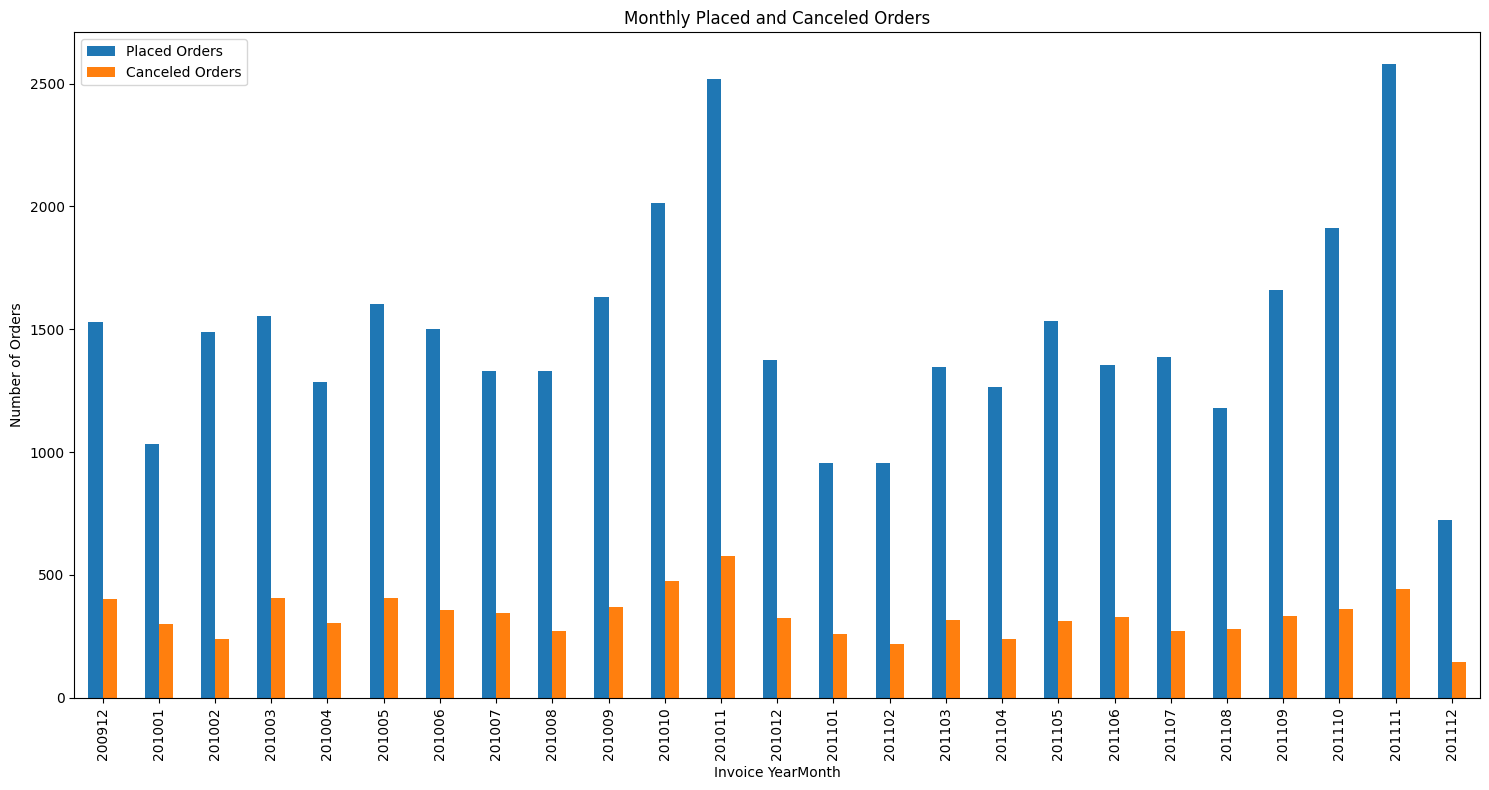

In [0]:
retail_df = retail_df.withColumn(
    "year_month_int", F.date_format("invoice_date", "yyyyMM").cast("int")
)

# canceled orders
retail_df = retail_df.withColumn(
    "is_canceled", F.col("invoice_no").startswith("C").cast("int")
)

# Count total orders and canceled orders per month
monthly_orders_df = retail_df.select("year_month_int", "invoice_no", "is_canceled") \
    .dropDuplicates(["year_month_int", "invoice_no"]) \
    .groupBy("year_month_int") \
    .agg(
        F.count("invoice_no").alias("total_orders"),
        F.sum("is_canceled").alias("canceled_orders")
    )

monthly_orders_df = monthly_orders_df.withColumn(
    "placed_orders", F.col("total_orders") - 2 * F.col("canceled_orders")
)

monthly_orders_df.orderBy("year_month_int").show()




# pandas for plotting
order_status_pd = monthly_orders_df.select(
    "year_month_int", "placed_orders", "canceled_orders"
).orderBy("year_month_int").toPandas()

order_status_pd.rename(columns={"year_month_int": "InvoiceYearMonth"}, inplace=True)

monthly_placed_orders_df = pd.DataFrame({
    'InvoiceYearMonth': order_status_pd['InvoiceYearMonth'].astype(str),
    'Placement': order_status_pd['placed_orders']
})

monthly_canceled_orders_df = pd.DataFrame({
    'InvoiceYearMonth': order_status_pd['InvoiceYearMonth'].astype(str),
    'Cancellation': order_status_pd['canceled_orders']
})

df = pd.concat([monthly_placed_orders_df, monthly_canceled_orders_df['Cancellation']], axis=1)

plt.figure(figsize=(15, 8))
df.plot(
    x='InvoiceYearMonth',
    y=['Placement', 'Cancellation'],
    kind='bar',
    figsize=(15, 8),
    rot=90
)
plt.xlabel('Invoice YearMonth')
plt.ylabel('Number of Orders')
plt.title('Monthly Placed and Canceled Orders')
plt.legend(['Placed Orders', 'Canceled Orders'])
plt.tight_layout()
plt.show()

# Monthly Sales



year_month,sales_amount
201001,624032.8919999955
201002,533091.4260000042
201007,575236.3600000095
201004,590580.4319999823
200912,799847.1100000143
201006,679786.6099999842
201005,615322.8300000005
201003,765848.7609999765
201103,683267.0800000189
201104,493207.12100002496


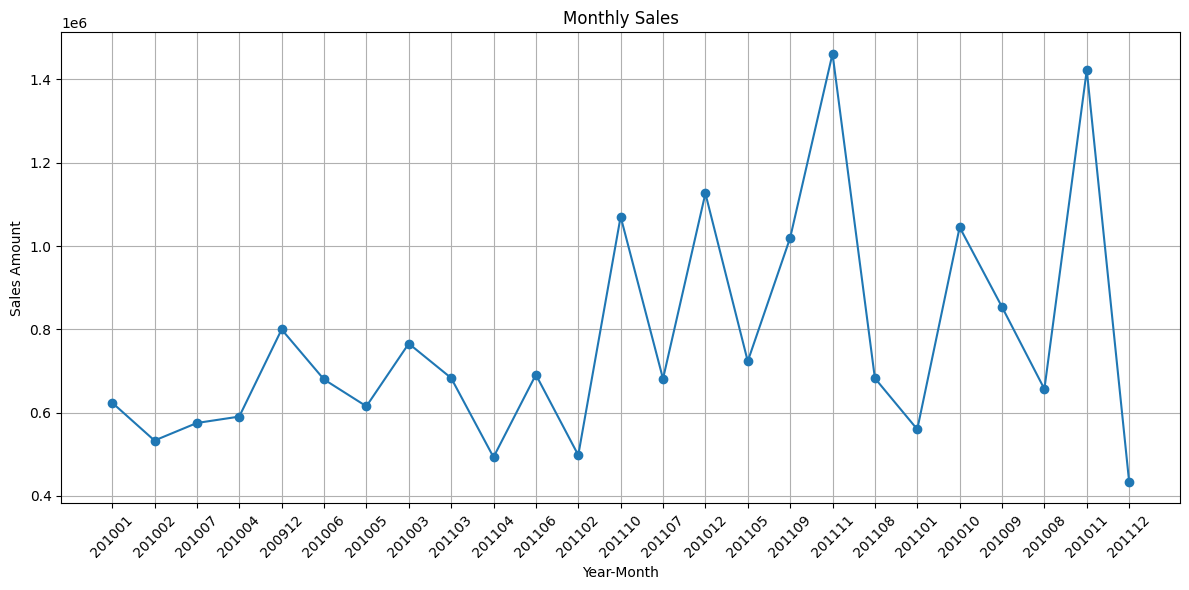

In [0]:

monthly_sales_df = retail_df.groupBy("year_month").agg(
    F.sum("item_total").alias("sales_amount")
)

display(monthly_sales_df)

# pandas for plotting
monthly_sales_pd = monthly_sales_df.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_pd["year_month"], monthly_sales_pd["sales_amount"], marker='o')
plt.title("Monthly Sales")
plt.xlabel("Year-Month")
plt.ylabel("Sales Amount")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Monthly Sales Growth



year_month,sales_amount,sales_growth_percentage
200912,799847.1100000143,null
201001,624032.8919999955,-21.980978089677127
201002,533091.4260000042,-14.573184709627766
201003,765848.7609999765,43.661804269943474
201004,590580.4319999823,-22.885501410375667
201005,615322.8300000005,4.18950521544184
201006,679786.6099999842,10.476416095268814
201007,575236.3600000095,-15.379863101448418
201008,656776.3399999854,14.175039282978311
201009,853650.4309999745,29.975819622246664


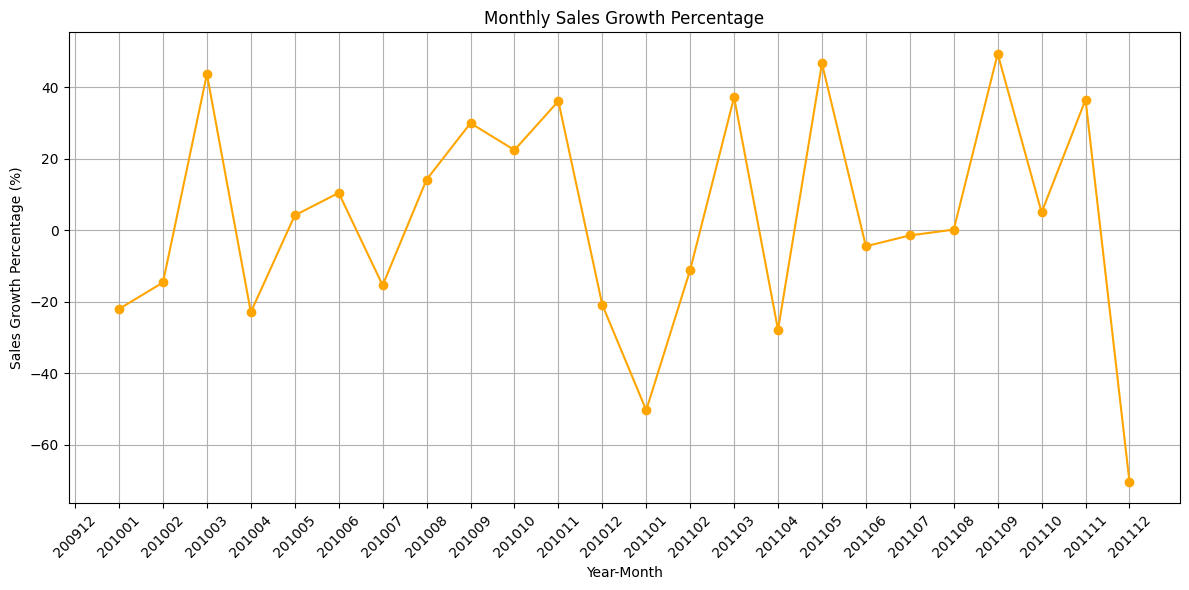

In [0]:

from pyspark.sql import Window

monthly_sales_df = retail_df.groupBy("year_month").agg(
    F.sum("item_total").alias("sales_amount")
)

monthly_sales_df = monthly_sales_df.orderBy("year_month")

monthly_sales_df = monthly_sales_df.withColumn(
    "sales_growth_percentage", 
    (F.col("sales_amount") - F.lag("sales_amount").over(Window.orderBy("year_month"))) / F.lag("sales_amount").over(Window.orderBy("year_month")) * 100
)

display(monthly_sales_df)

# Pandas for plotting
monthly_sales_growth_pd = monthly_sales_df.toPandas()


plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_growth_pd["year_month"], monthly_sales_growth_pd["sales_growth_percentage"], marker='o', color='orange')
plt.title("Monthly Sales Growth Percentage")
plt.xlabel("Year-Month")
plt.ylabel("Sales Growth Percentage (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Monthly Active Users



year_month,active_users
201103,1020
201001,786
201002,807
201010,1577
201009,1202
201104,899
201106,1051
201102,798
201110,1425
201008,964


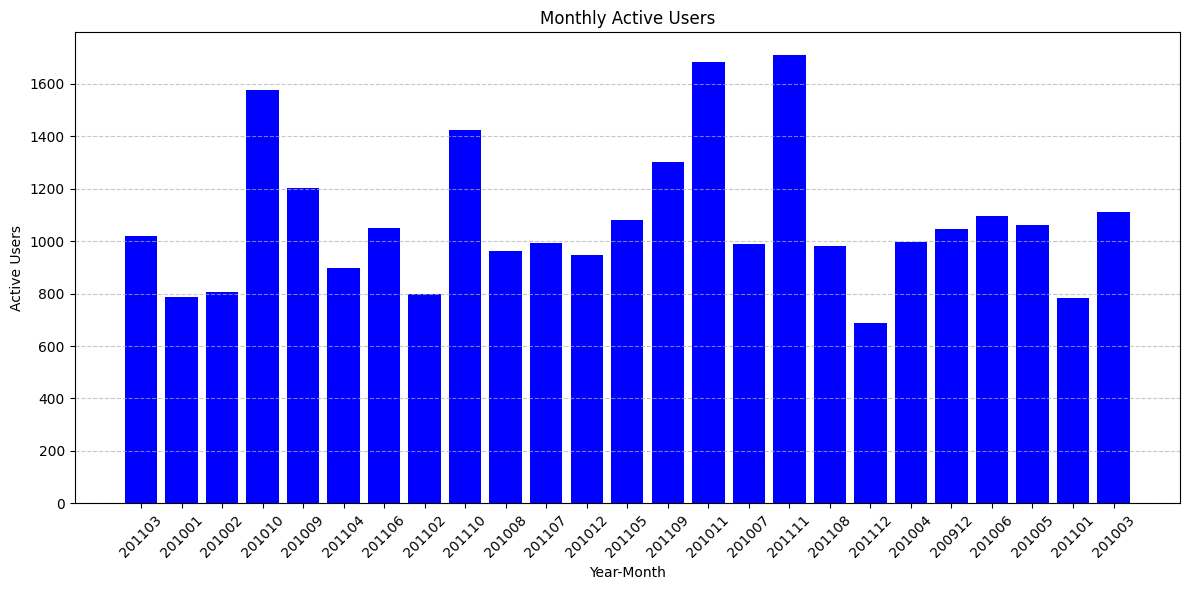

In [0]:

active_users_df = retail_df.groupBy("year_month").agg(
    F.countDistinct("customer_id").alias("active_users")
)

display(active_users_df)

# Pandas for plotting
active_users_pd = active_users_df.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(active_users_pd["year_month"], active_users_pd["active_users"], color='blue')
plt.title("Monthly Active Users")
plt.xlabel("Year-Month")
plt.ylabel("Active Users")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# New and Existing Users


year_month,existing_users,new_users
200912,0,1045
201001,392,394
201002,444,363
201003,675,436
201004,707,291
201005,808,254
201006,826,269
201007,805,183
201008,806,158
201009,960,242


<Figure size 1200x600 with 0 Axes>

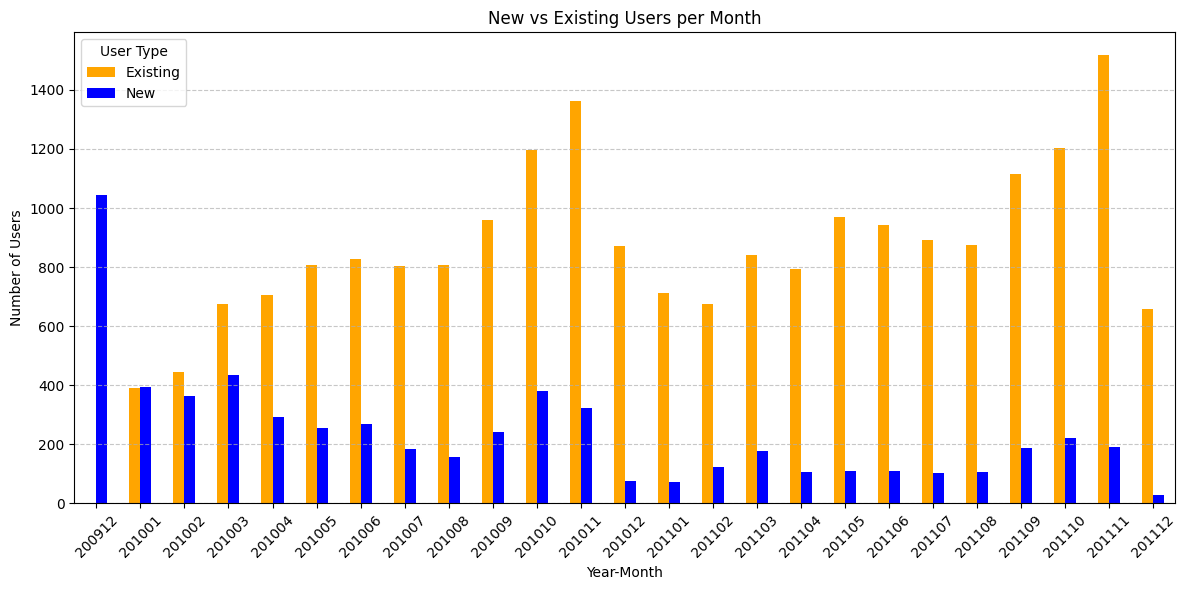

In [0]:
# first purchase month for each user
first_purchase_df = retail_df.groupBy("customer_id").agg(
    F.min("invoice_date").alias("first_purchase_date")
)

# year_month column for the first purchase
first_purchase_df = first_purchase_df.withColumn(
    "first_purchase_year_month", F.date_format("first_purchase_date", "yyyyMM")
)

retail_with_first_purchase = retail_df.join(
    first_purchase_df, on="customer_id", how="left"
)

retail_with_first_purchase = retail_with_first_purchase.withColumn(
    "user_type",
    F.when(
        F.date_format("invoice_date", "yyyyMM") == F.col("first_purchase_year_month"),
        "New"
    ).otherwise("Existing")
)


user_type_count_df = retail_with_first_purchase.groupBy(
    "year_month", "user_type"
).agg(
    F.countDistinct("customer_id").alias("user_count")
)

pivoted_df = user_type_count_df.groupBy("year_month").pivot("user_type").sum("user_count")
pivoted_df = pivoted_df.withColumnRenamed("New", "new_users").withColumnRenamed("Existing", "existing_users").orderBy("year_month")

display(pivoted_df)



# Pandas for plotting
user_type_count_pd = user_type_count_df.toPandas()

plt.figure(figsize=(12, 6))

user_type_data = user_type_count_pd.pivot(index="year_month", columns="user_type", values="user_count").fillna(0)

user_type_data.plot(kind='bar', stacked=False, figsize=(12, 6), color=['orange', 'blue'])

plt.title("New vs Existing Users per Month")
plt.xlabel("Year-Month")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.legend(title="User Type")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Finding RFM


In [0]:
from pyspark.sql import functions as F

retail_df = retail_df.withColumn("item_total", F.col("quantity") * F.col("unit_price"))

analysis_date = F.lit("2012-01-01")

# Recency 
recency_df = retail_df.groupBy("customer_id").agg(
    F.datediff(analysis_date, F.max(F.col("invoice_date").cast("date"))).alias("recency")
)


# Frequency
frequency_df = retail_df.groupBy("customer_id").agg(
    F.countDistinct("invoice_no").alias("frequency")
)

# Monetary
monetary_df = retail_df.groupBy("customer_id").agg(
    F.sum("item_total").alias("monetary")
)

rfm_df = recency_df.join(frequency_df, on="customer_id", how="inner") \
                   .join(monetary_df, on="customer_id", how="inner") \
                   .orderBy("customer_id")

rfm_df.show(20)


+-----------+-------+---------+------------------+
|customer_id|recency|frequency|          monetary|
+-----------+-------+---------+------------------+
|      12346|    348|       17|-64.67999999999981|
|      12347|     25|        8| 5633.320000000001|
|      12348|     98|        5|            2019.4|
|      12349|     41|        5|           4404.54|
|      12350|    333|        1|334.40000000000003|
|      12351|    398|        1|            300.93|
|      12352|     59|       13|           1889.21|
|      12353|    227|        2|406.75999999999993|
|      12354|    255|        1|            1079.4|
|      12355|    237|        2| 947.6099999999999|
|      12356|     45|        6| 6373.679999999999|
|      12357|     56|        3| 18287.65999999999|
|      12358|     24|        5|3887.0700000000006|
|      12359|     30|       14| 8714.890000000001|
|      12360|     75|        9|4212.8899999999985|
|      12361|    310|        4|            511.25|
|      12362|     26|       14|

In [0]:
retail_df.agg(
    F.min(F.col("invoice_date")).alias("min_invoice_date"),
    F.max(F.col("invoice_date")).alias("max_invoice_date")
).show()


+-------------------+-------------------+
|   min_invoice_date|   max_invoice_date|
+-------------------+-------------------+
|2009-12-01 07:45:00|2011-12-09 12:50:00|
+-------------------+-------------------+



In [0]:
recency_df.show(20)


+-----------+-------+
|customer_id|recency|
+-----------+-------+
|      15194|      3|
|      15057|    275|
|      17043|     32|
|      16742|     46|
|      17048|    117|
|      15375|    690|
|      16530|    668|
|      15371|    662|
|      12568|    644|
|      15437|    262|
|      18196|     95|
|      15173|    380|
|      13723|    217|
|      17499|    289|
|      16896|    555|
|      17971|    548|
|      15432|     23|
|      13206|    400|
|      16673|    679|
|      13658|      9|
+-----------+-------+
only showing top 20 rows



In [0]:
#SAME AS ABOVE BUT DIFFERENT

from pyspark.sql import functions as F

retail_df = retail_df.withColumn("item_total", F.col("quantity") * F.col("unit_price"))


analysis_date = F.lit(retail_df.agg(F.max("invoice_date").cast("date")).collect()[0][0])


recency_df = retail_df.groupBy("customer_id").agg(
    F.datediff(analysis_date, F.max("invoice_date")).alias("recency")
)

frequency_df = retail_df.groupBy("customer_id").agg(
    F.countDistinct("invoice_no").alias("frequency")
)

monetary_df = retail_df.groupBy("customer_id").agg(
    F.sum("item_total").alias("monetary")
)

rfm_df = recency_df.join(frequency_df, on="customer_id", how="inner") \
                  .join(monetary_df, on="customer_id", how="inner")

rfm_df = rfm_df.orderBy("customer_id")

print("RFM Analysis Table:")
rfm_df.show(10)

print("RFM Summary Statistics:")
rfm_df.describe().show()

RFM Analysis Table:
+-----------+-------+---------+------------------+
|customer_id|recency|frequency|          monetary|
+-----------+-------+---------+------------------+
|      12346|    325|       12|          77556.46|
|      12347|      2|        8| 5633.320000000001|
|      12348|     75|        5|            2019.4|
|      12349|     18|        4|           4428.69|
|      12350|    310|        1|334.40000000000003|
|      12351|    375|        1|            300.93|
|      12352|     36|       10|           2849.84|
|      12353|    204|        2|406.75999999999993|
|      12354|    232|        1|            1079.4|
|      12355|    214|        2| 947.6099999999999|
+-----------+-------+---------+------------------+
only showing top 10 rows

RFM Summary Statistics:
+-------+------------------+------------------+------------------+------------------+
|summary|       customer_id|           recency|         frequency|          monetary|
+-------+------------------+----------------